In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
%load_ext tensorboard
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=True,
    min_cuda_compute_capability=None
)

2.0.0


True

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import patches
from patches import save_images
from tqdm.notebook import tqdm

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Setting perameters

In [4]:
im_width = 256
im_height = 256
path_train = r'/data/student/training/'
#path_test = os.path.join( os.getcwd(), 'input',  'test')
classes = ['dark_dense_distribution', 'Elongated_nuclei','light_dense_istribution','light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed']

In [5]:
path_train + 'images'

'/data/student/training/images'

In [6]:
palette = np.array([
    [128,0,0],
    [128,8,0],
    [0,0,255],
    [0,128,0],
    [255,255,0],
    [255,105,180],
    [255,0,0],
    [255,165,0],
    [128,128,128]], dtype=np.uint8)
palette = np.divide(palette, 255)

In [7]:
palette.shape

(9, 3)

In [8]:
palette

array([[0.50196078, 0.        , 0.        ],
       [0.50196078, 0.03137255, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.50196078, 0.        ],
       [1.        , 1.        , 0.        ],
       [1.        , 0.41176471, 0.70588235],
       [1.        , 0.        , 0.        ],
       [1.        , 0.64705882, 0.        ],
       [0.50196078, 0.50196078, 0.50196078]])

In [9]:
def one_hot_encode( mask, palette):
        """
        Converts mask to a one-hot encoding specified by the semantic map.
        """
        one_hot_map = []
        for colour in palette:
            class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        
        return one_hot_map

In [10]:
def save_patches(path, ext):
    ids = next(os.walk(path))[2]
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = imread(path + id_)
        patch = patches.extract_patches(img, overlap_allowed =0 ,patchshape =[im_height,im_width], crop_fraction_allowed = 0)
        save_images(patches=patch, n=n, ext=ext, dir_f = path + 'patches/')

# Testing the save function

In [17]:
save_patches('/data/student/training/testIm/','.tif')

/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# only run this cell if you dont have patches

In [11]:
# patches for images 
path_images = path_train + 'images/'
save_patches(path_images, '.tif')
path_masks = path_train + 'masks/'
save_patches(path_masks, '.png')

/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (128403763 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [12]:
def get_data(path, palette, train=True):
    ids = next(os.walk(path + "masks/patches"))[2]
    X = [] #np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = [] #np.zeros((len(ids), im_height, im_width, palette.shape[0]), dtype=np.float32)
        masks = [] #np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        if train:
            mask = imread(path + '/masks/patches/' + id_)
            if mask.mean() > 200:
                ids.remove(id_)
                continue
            y_mask = img_to_array(mask)
            y_mask = resize(y_mask, (im_height, im_width, 3), mode='constant', preserve_range=True)
            y.append(one_hot_encode(y_mask, palette))
            #y[n] = mask/255
            masks.append(y_mask)
    
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = imread(path + '/images/patches/'+ id_.replace(".png", ".tif") )
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_height, im_width, 3), mode='constant', preserve_range=True)
        X.append(x_img)
        
    
    print('Done!')
    if train:
        return X, y, masks
    else:
        return X

In [ ]:
X, y, masks = get_data(path_train, train=True, palette=palette)

Getting and resizing images ... 


/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [16]:
X = np.asarray(X)
X.shape

(961, 256, 256, 3)

In [17]:
y_masks = np.asarray(masks)
y_masks = y_masks[:,:,:,:3]
y_masks.shape

(961, 256, 256, 3)

In [106]:
npsmasks = npmasks[:,:,:,:3]

In [111]:
npmasks[0][0][0]

array([255., 255., 255.,   0.], dtype=float32)

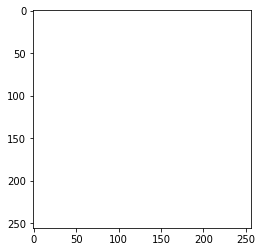

In [112]:
plt.imshow(npsmasks[15].astype(np.uint8))

In [22]:
ids = next(os.walk(path_train + "masks"))[2]
print(len(ids))

34794


In [13]:
y.shape

(567, 256, 256, 9)

In [77]:
(npmasks[0][0][0]), masks[0][0][0]

(array([254.16666667, 254.5       ,  42.33333333]),
 array([254.16666667, 254.5       ,  42.33333333]))

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_masks, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [961, 0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [115]:
def plot_img(ix):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(X_train[ix].astype(np.uint8))
    ax[0].set_title('Image')

    ax[1].imshow(y_train[ix].astype(np.uint8))
    ax[1].set_title('mask');


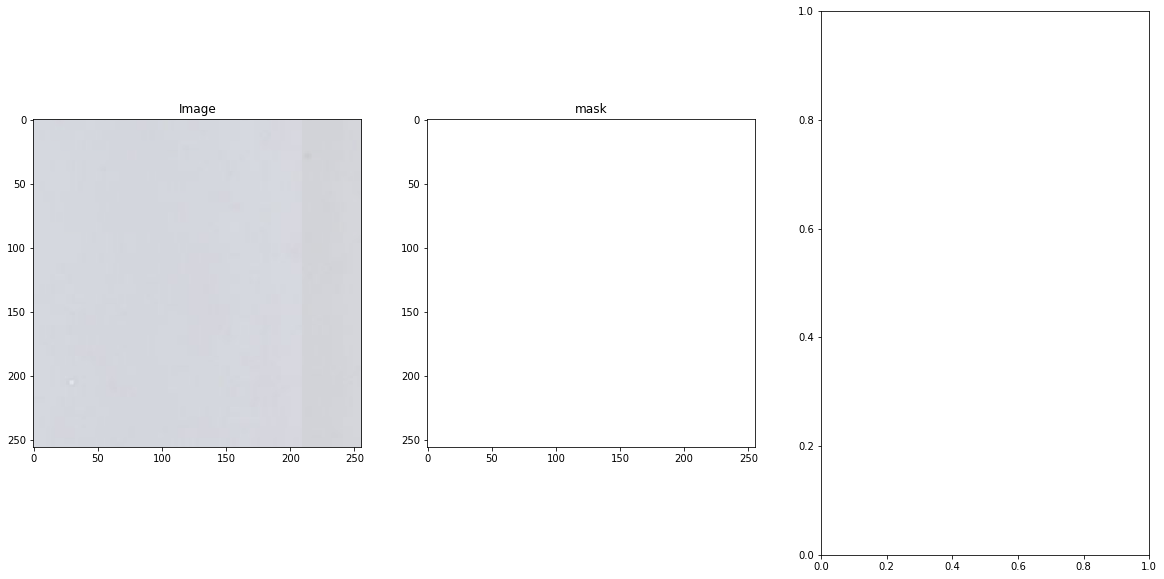

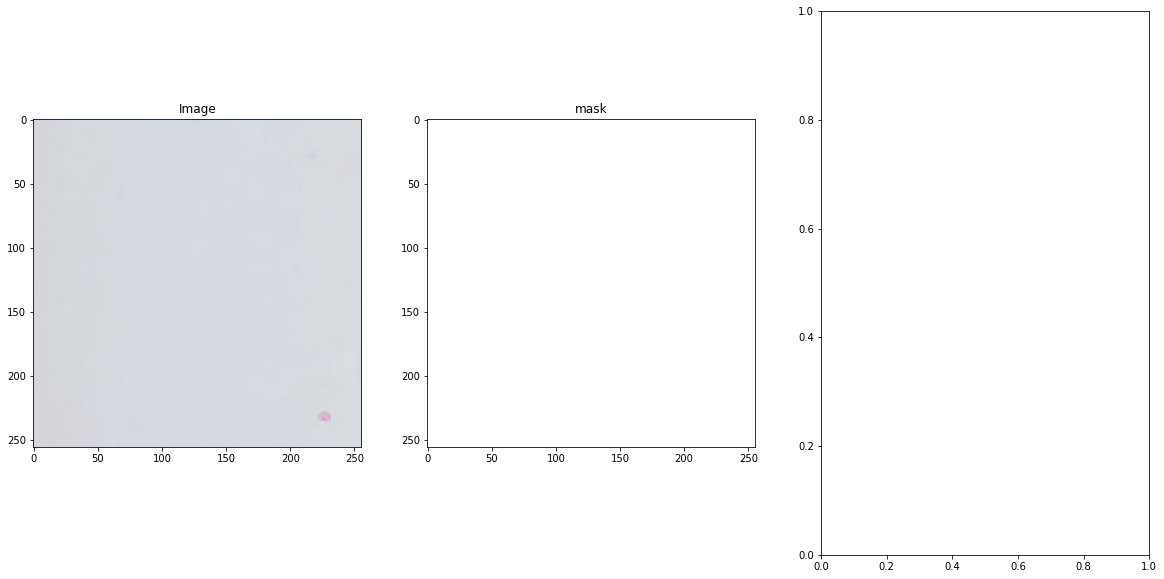

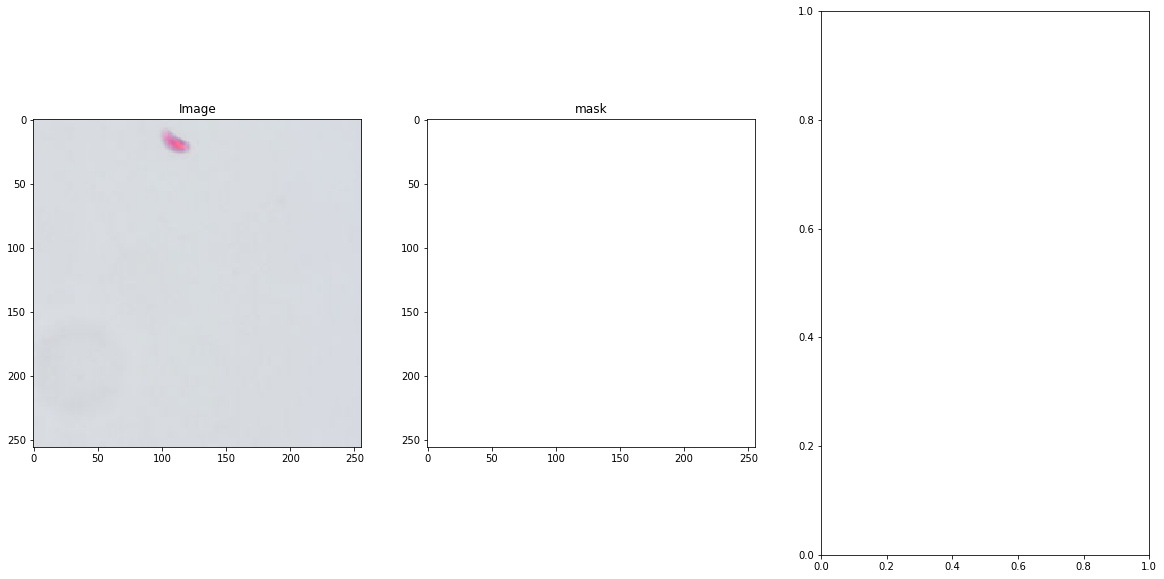

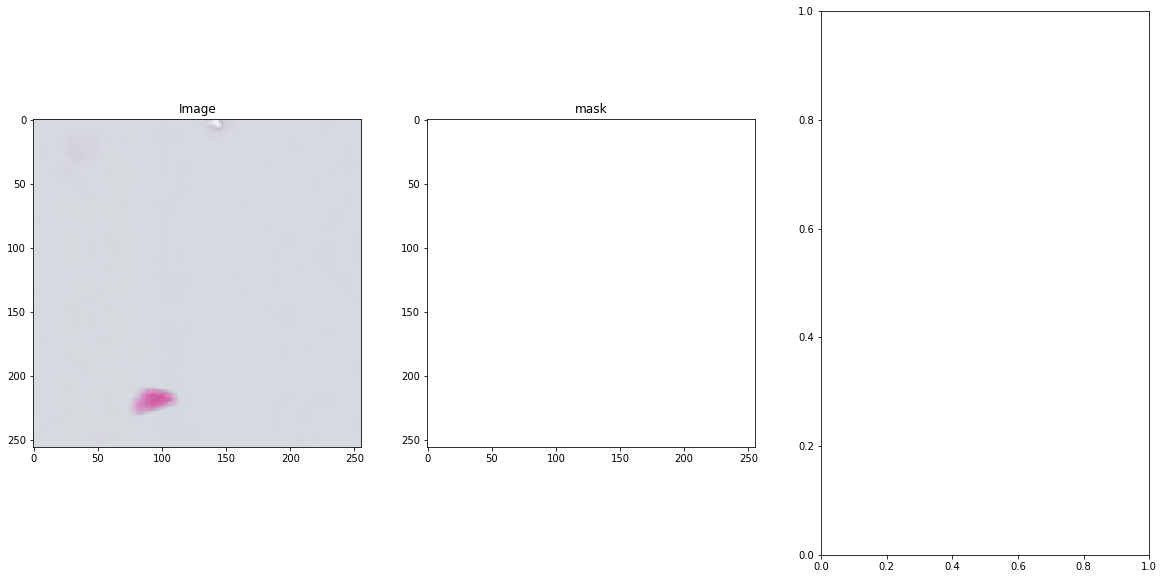

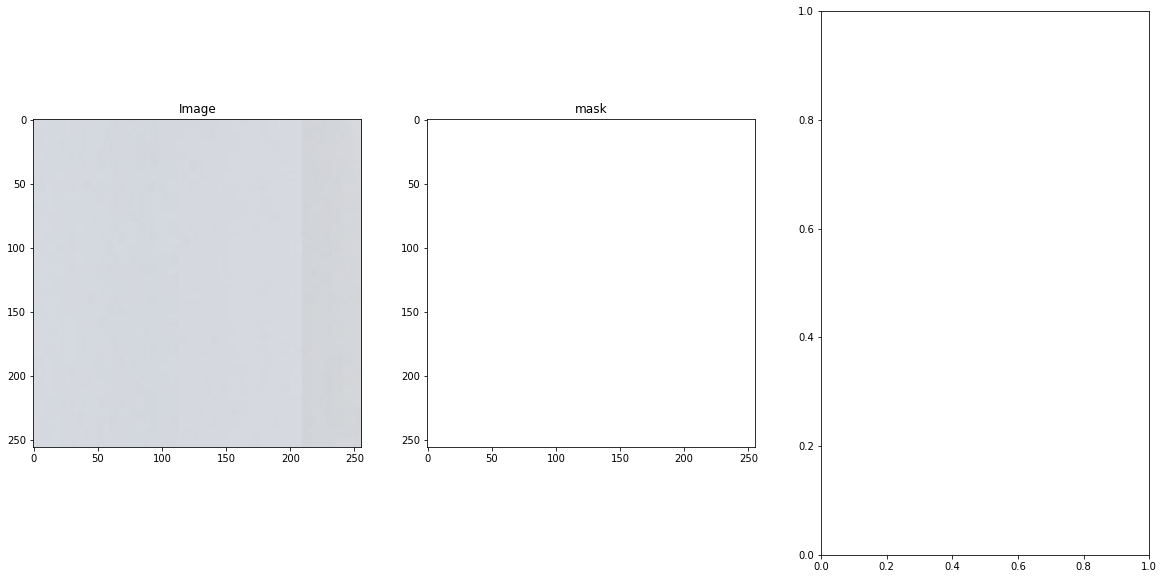

In [116]:
for i in range(0,5):
    ix = random.randint(0, len(X))
    plot_img(i)

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [17]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(9, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [19]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef, 'acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping( patience=10, verbose=1),
    ReduceLROnPlateau( factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-basic_tf2.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1)
]

In [22]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 408 samples, validate on 86 samples
Epoch 1/100
384/408 [===========================>..] - ETA: 6:35 - loss: 0.6200 - dice_coef: 0.0036 - acc: 0.465 - ETA: 5:17 - loss: 0.7190 - dice_coef: 0.0018 - acc: 0.420 - ETA: 4:31 - loss: 0.6416 - dice_coef: 0.0012 - acc: 0.409 - ETA: 3:36 - loss: 0.6404 - dice_coef: 9.0289e-04 - acc: 0.391 - ETA: 2:58 - loss: 0.6204 - dice_coef: 7.2371e-04 - acc: 0.383 - ETA: 2:28 - loss: 0.6089 - dice_coef: 6.9642e-04 - acc: 0.381 - ETA: 2:02 - loss: 0.5989 - dice_coef: 7.1147e-04 - acc: 0.379 - ETA: 1:38 - loss: 0.6251 - dice_coef: 9.1925e-04 - acc: 0.367 - ETA: 1:15 - loss: 0.6025 - dice_coef: 0.0017 - acc: 0.3697    - ETA: 54s - loss: 0.5880 - dice_coef: 0.0024 - acc: 0.369 - ETA: 34s - loss: 0.5704 - dice_coef: 0.0035 - acc: 0.37 - ETA: 14s - loss: 0.5621 - dice_coef: 0.0045 - acc: 0.3713
Epoch 00001: val_loss improved from inf to 0.40558, saving model to model-unet-basic_tf2.h5
408/408 [==============================] - 252s 618ms/sample - loss: 

Epoch 9/100
384/408 [===========================>..] - ETA: 3:26 - loss: 0.2652 - dice_coef: 0.4825 - acc: 0.466 - ETA: 3:15 - loss: 0.2903 - dice_coef: 0.4700 - acc: 0.506 - ETA: 2:56 - loss: 0.2361 - dice_coef: 0.5333 - acc: 0.495 - ETA: 2:37 - loss: 0.2374 - dice_coef: 0.5191 - acc: 0.506 - ETA: 2:20 - loss: 0.2514 - dice_coef: 0.5008 - acc: 0.493 - ETA: 2:00 - loss: 0.2615 - dice_coef: 0.4829 - acc: 0.501 - ETA: 1:43 - loss: 0.2549 - dice_coef: 0.5049 - acc: 0.499 - ETA: 1:25 - loss: 0.2514 - dice_coef: 0.5055 - acc: 0.495 - ETA: 1:07 - loss: 0.2442 - dice_coef: 0.5117 - acc: 0.491 - ETA: 49s - loss: 0.2523 - dice_coef: 0.5047 - acc: 0.494 - ETA: 31s - loss: 0.2400 - dice_coef: 0.5143 - acc: 0.49 - ETA: 13s - loss: 0.2406 - dice_coef: 0.5225 - acc: 0.4926
Epoch 00009: val_loss did not improve from 0.40051
408/408 [==============================] - 239s 585ms/sample - loss: 0.2396 - dice_coef: 0.5329 - acc: 0.4933 - val_loss: 0.5119 - val_dice_coef: 0.0000e+00 - val_acc: 0.4374
Epoc

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), 
         np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model-unet-basic_tf2.h5')

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


In [ ]:
# Check if training data looks all right
for i in range(0,10):
    plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
path_test = os.path.join( os.getcwd(), 'input',  'test')
X_test, y_test = get_data(path_test, train=True)

In [ ]:
preds_test = model.predict(X_test, verbose=1)

In [ ]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=15)

In [ ]:
path_big = os.path.join(os.getcwd(), 'input', 'big')
X_big, y_big = get_data(path_big, train=True)

In [ ]:
preds_big = model.predict(X_big, verbose=1)

In [ ]:
preds_big_t = (preds_big > 0.5).astype(np.uint8)
plot_sample(X_big, y_big, preds_big, preds_big_t, ix=0)

In [ ]:
plt.imshow(X_big[0])

In [ ]:
for i in range(10):
    plot_sample(X_test, y_test, preds_test, preds_test_t, ix=i)

In [23]:
%tensorboard --logdir log\s

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7832.